# Elliptic Curve Cryptography

## Requirements
- Python 3.6 +
- Matplotli
- PyCryptoDome
- Numpy

In [1]:
from utils import generate_keys, build_known_curves, hash_message
from ecc import *
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Generate Elliptic Curves

### Orders of Elliptic Curves
The *order* of the group is defined as the number of points in the elliptic curve on $\mathbb{F}_p$.
### Orders of Subgroup
A cyclic subgroup is a subgroup which elements are repeating cyclically. For example, consider the curve $y^2 \equiv x^3 + 2x + 3 \pmod {97}$ and point $P = (3, 6)$.

$0P = 0 \\
1P = (3, 6) \\
2P = (80, 10) \\
3P = (80, 87) \\
4P = (3, 91) \\
5P = 0 \\
6P = (3, 6) \\
7P = (8, 10) \\
\cdots 
$

We can observe that $kP = (k\mod 5) P$. $P$ is called *generator* or *base point* and $5$ is the order of the subgroup. 

Formally, the order of the subgroup *generated* by $P$ is the smallest positive integer $n$ such that $nP = 0$
<br/><br/>

**Lagranges's theorem** 

If an elliptic curve contains $N$ points and one of its subgroups contains $n$ points, then is a $n$ divisor of $N$.

### Generating A Curve
In practice, we usually revert the order mentioned above. We first select a desired subgroup order $n$ that is high enough and then find the base point, denoted as $G$.

Here is a common procedure:
1. Calculate the order $N$ of the elliptic curve.
1. Choose the order $n$ of the subgroup, where $n$ is and is a divisor of $N$.
1. Compute the cofactor $h = N/n$. Typcially we want $h$ to be small and ideally $h = 1$.
1. Choose a random point $P$ on the curve.
1. Compute $G = hP$.
1. If $G$ is 0, go back to step 4.
Now we have found a generator $G$ of a subgroup with order $n$ and cofactor $h$.

In [2]:
print ("Curve Generation Demo")
p = 3631
(a, b, G, n, h) = generate_curve(p)
while h > 8:
    print ("h > 8: Generating new curve")
    (a, b, G, n, h) = generate_curve(p)
parameters = (p, a, b, G, n, h)
print ("Generated curve:")
print (f"p: {p}, a: {a}, b: {b}, \nG: {G}, n: {n}, h: {h}")

Curve Generation Demo
h > 8: Generating new curve
h > 8: Generating new curve
h > 8: Generating new curve
Generated curve:
p: 3631, a: 13, b: -2, 
G: (0x766, 0x633), n: 619, h: 6


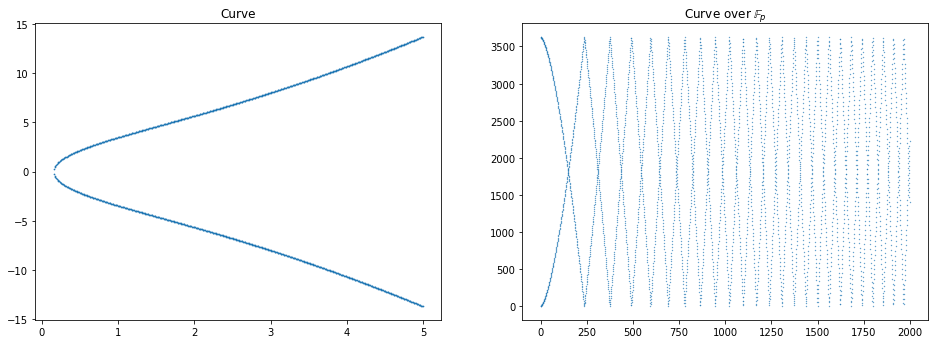

In [3]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Curve')

# Plot the curve
x = np.arange(-5, 5, 0.01) 
y_2 = x ** 3 + a * x + b
idx = np.where(y_2 >= 0)
y = np.sqrt(y_2[idx])
x = np.concatenate([x[idx], x[idx]])
y = np.concatenate([y, -y])
ax1.scatter(x, y, s=0.5)

# Plot the curve over the finite field F_p
ax2 = fig.add_subplot(222)
ax2.title.set_text(r'Curve over $\mathbb{F}_p$')
x = np.arange(-2, 2000) 
y_2 = x ** 3 + a * x + b
idx = np.where(y_2 >= 0)
y = np.sqrt(y_2[idx])
x = np.concatenate([x[idx], x[idx]]) % p
y = np.concatenate([y, -y]) % p
ax2.scatter(x, y, s=0.1)

plt.show()

## Load Curve

In [4]:
# Load a publicly-known curve , secp256k1
curves = build_known_curves()
(p, a, b, G, n, h) = curves['secp256k1']
# Option 2: Add customize curve to known_curves.json,
# and load with parameters = curves[<<curve_name>>]
(p, a, b, G, n, h) = curves['comp3632']

## Generate Private/Public Key Pairs
Generate a private/public key pair $(k, H)$ based on elliptic curve parameters $(p, a, b, G, n, h)$, where $H = kG$

1. Select $d \in [1, n]$
2. Calculate $H = d G$
3. Repeat step 1 if $H = 0$

In [5]:
parameters = (p, a, b, G, n, h)
private_key, public_key = generate_keys(parameters)
print (f"Private Key: \n {hex(private_key)}")
print (f"Public Key: \n {public_key}")

Private Key: 
 0xae
Public Key: 
 (0x675, 0x522)


## Elliptic-curve  Diffie–Hellman (ECDH)
Elliptic-curve Diffie-Hellman (ECDH) is a key exchange protocol that generates a shared secret key based on two individual public-private key pairs. 

The key exchange process follows this procedure:
1. Alice and Bob each generates a pair of (private, public) key pair, $(k_A, H_A), (k_B, H_B)$ based on elliptic curve parameters $(p, a, b, G, n, h)$, where $H_A = k_A G$ and $H_B = k_B G$
2. Alice calculates $S_A = k_A H_B$ and Bob calculates $S_B = k_B H_A$. 
3. We can see $S_A = k_A H_B = k_A (k_B G) = k_B (k_A G) = k_B H_A = S_B$. Thus Alice and Bob has the same shared key $S = S_A = S_B$. They can then do symmetric key cryptography or other applications.

In [6]:
parameters = (p, a, b, G, n, h) 
d1, H1 = generate_keys(parameters)
d2, H2 = generate_keys(parameters) 
S1 = ECDH(d1, H2, parameters)
S2 = ECDH(d2, H1, parameters)
print ("S1:", S1)
print ("S2:", S2)
# Results should be the same

S1: (0xd6b, 0xd13)
S2: (0xd6b, 0xd13)


## Elliptic Curve Digital Signature Algorithm (ECDSA)

ECDSA is a algorithm that utilizes elliptic curves to ”sign” a message, i.e. to prove the message comes from an authorized sender.

### Sign
The **signing** part of the algorithm can be described as the following:

Let the curve parameters be $(p, a, b, G, n, h)$. Suppose Alice wants to sign a message $m$.

1. Alice generates a key pair $(d_A, H_A = d_A G)$
2. Calculate $z = $ hash($m$), then pad or delete bits from $z$ such that $z$ has the same bit-length as $n$
3. Generate a random integer $k \in [1, n-1]$
4. Calculate $P = kG$. Let $P = (P_x, P_y)$ and $r = P_x$. If $r = 0$, go to step 1.
5. Calculate $s = k^{-1} (z + r d_A) \pmod n$. If $s = 0$, go to step 2.
6. Return the signature $(r, s)$

In [7]:
message = b"I love COMP3632!"
z = hash_message(message, n) # Hash and pad/unpad the message
d, H = generate_keys(parameters)
r, s = ECDSA_sign(d, z, parameters) # (r, s): Signature 
print (f"Signature (r, s): ({hex(r)}, {hex(s)})")

Signature (r, s): (0x2fe, 0x475)


### Verify
To **verify** a signature $(r, s)$, we do the following:
1. Calculate $u_1 = s^{-1} z$ and $u_2 = s^{-1} r$
2. Calculate $P = u_1 G + u_2 H$
3. If $r \equiv P_x \pmod n$, the signature is verified.

In [8]:
message = b"I love COMP3632!"
z = hash_message(message, n) # Hash and pad/unpad the message d, H = generate_keys(parameters)
r, s = ECDSA_sign(d, z, parameters) # (r, s): Signature
verified = ECDSA_verify(H, z, r, s, parameters) # True if the message is authenticated 
print (verified)

True


### Vulnerabilities
If the key $k$ in the algorithm is used multiple times, the secret key $d_A$ could be exposed. Suppose messages and signatures $z_1, (r_1, s_1)$ and $z_2, (r_2, s_2)$ are signed with the same $k$. We have 
$$
k = (z_1 - z_2) (s_1 - s_2)^{-1} \pmod n
$$

We can then get
$$
d_A = r_1^{-1} (s_1 k - z_1) \pmod n
$$

In [9]:
message1 = b"I love COMP3632!"
d, H = generate_keys(parameters)
z1 = hash_message(message1 , n)
print (f"Original Key is {hex(d)}") # <---------------- Original Key
k = 10 # Suppose we fix some k
r1, s1 = (ECDSA_fixed_k(k, d, z1, parameters)) 
message2 = b"I like COMP3632!"
z2 = hash_message(message2 , n)
r2, s2 = (ECDSA_fixed_k(k, d, z2, parameters))
print (f"Hacked Key is {ECDSA_hack(z1, r1, s1, z2, r2, s2, n)}") # <----------------Hacked Key

Original Key is 0x178
Hacked Key is 0x178


## Elliptic Curve Integrated Encryption Scheme (ECIES)
ECIES is a hybrid encryption scheme that provides security based on ECC.

We assume Alice and Bos has shared the following information:
- Cryptographic suites
    - Key Derivation Function (KDF), e.g. PBKDF2
    - Message Authentication Code (MAC), e.g. HMAC-SHA-1-160 with 160-bit keys
    - Symmetric Encryption Scheme, e.g. AES
- Bob's public key $H_B$
- Optional: Salt and IV for encryption


In [10]:
k_B, H_B = generate_keys(parameters)

To send a message $m$ to Bob, Alice follows this procedure:

1. Generate a random integer $r \in [1, n-1]$
1. Calculate $R = rG$
1. Calculate $P = r H_B$
1. Calculate symmetric encryption key $k_E$ and MAC key $k_M$, where $k_E || k_M = KDF(P_x)$
1. Encrypt message and get $c = E_{k_E}(m)$
1. Calculate $d =$ MAC$_{k_M}(c)$
1. Send $(R, c, d)$ (with optional: salt, iv) to Bob

In [11]:
message = b'I love COMP3632!'
print (f"Original Message: {str(message)[2:-1]}") # <---------------- Original Message
(R, c, d, salt, iv) = ECIES_Encrypt(message, H_B, parameters) 
print (f"Ciphertext: {c.hex()}") # <---------------- Encrypted Message

Original Message: I love COMP3632!
Ciphertext: 1b8559d3bf4d91d2a5dd5693fc155c37715c13f9c2387f94f7ed4b212a50734a


For Bob to decrypt the message $(R, c, d)$  (with optional: salt, iv):
1. Calculate $P = k_B R$ where $k_B$ is Bob's secret key
1. Calculate $k_E || k_M = KDF(P_x)$
1. Use MAC to check if $d = $ MAC$_{k_M}(c)$  
1. If message is authenticated, decrypt the message $m = E^{-1}_{k_E}(c)$


In [12]:
msg = ECIES_Decrypt(R, c, d, salt, iv, k_B, parameters)
print (f"Decrypted Message: {str(msg)[2:-1]}") # <---------------- Decrypted Message

Decrypted Message: I love COMP3632!
